In [6]:
!chmod +x setup.sh; ./setup.sh

mkdir: cannot create directory ‘data’: File exists
./setup.sh: line 4: kaggle: command not found
unzip:  cannot find or open 140k-real-and-fake-faces, 140k-real-and-fake-faces.zip or 140k-real-and-fake-faces.ZIP.


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
from typing import Tuple, Optional

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms

%load_ext autoreload
%autoreload 2
from scripts.lib import create_df, img_to_matrix, clip_img, compose
from scripts.models.vggnet import VGGNet
from scripts.models.mesonet import MesoNet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device=}')

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fcc642e86d0>>
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


device=device(type='cpu')


## Loading data files into Datasets

In [2]:
TRAIN_PATH = "./data/real_vs_fake/real-vs-fake/train/"
TEST_PATH = "./data/real_vs_fake/real-vs-fake/test/"
VAL_PATH = "./data/real_vs_fake/real-vs-fake/val/"

In [20]:
train_df = create_df(TRAIN_PATH).head(5000)
val_df = create_df(VAL_PATH).head(1000)
test_df = create_df(TEST_PATH).head(1000)

train_df.shape, test_df.shape, val_df.shape

((100000, 2), (20000, 2), (20000, 2))

In [47]:
class FacesDataset(Dataset):
    def __init__(self, data: pl.DataFrame, path: str, clip: bool=False) -> None:
        self.data = data
        self.path = path
        self.clip = clip
        self.contrast = transforms.ColorJitter(contrast=1.5)
    
    def __len__(self) -> int:
        return self.data.shape[0]
    
    def __getitem__(self, idx: int) -> Tuple[np.ndarray, int]:
        data = self.data.slice(idx, 1)
        face, label = data['file'].item(), data['label'].item()
        path = self.path + ('fake/' if torch.argmax(label) == 0 else 'real/')
        img = compose(
            img_to_matrix,
            lambda x: clip_img(x, 224 if self.clip else 256),
            self.contrast)(path + face)
        return img, label

In [48]:
train_loader = DataLoader(FacesDataset(train_df, TRAIN_PATH, clip=True), shuffle=True, batch_size=64)
val_loader = DataLoader(FacesDataset(val_df, VAL_PATH, clip=True), batch_size=64)
test_loader = DataLoader(FacesDataset(test_df, TEST_PATH, clip=True), batch_size=64)

len(train_loader), len(val_loader), len(test_loader)

(1563, 313, 313)

In [67]:
faces, labels = next(iter(train_loader))

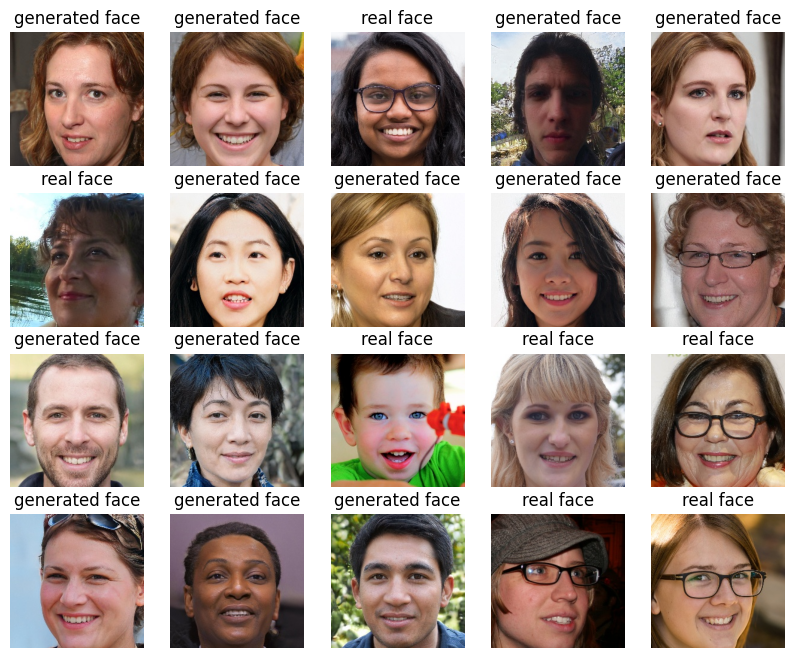

In [31]:
w, h = 8, 8
fig = plt.figure(figsize=(10, 8))
columns, rows = 5, 4

faces, labels = next(iter(train_loader))

for i in range(1, columns * rows + 1):
    fig.add_subplot(rows, columns, i)
    plt.title("generated face" if torch.argmax(labels[i]) == 0 else "real face")
    plt.imshow(faces[i].to(dtype=torch.uint8))
    plt.axis('off')

plt.show()

In [55]:
vggnet = VGGNet()
vggnet

VGGNet(
  (layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer_3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer_4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer_5): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3

In [ ]:
epochs = 10
lr = 3e-3
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=lr)


train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(1, epochs + 1):
    vggnet.train()
    running_loss, acc = [], []

    # training loop
    for idx, (faces, labels) in enumerate(train_loader):
        torch.permute(faces, (0, 3, 2, 1)).to(device)
        labels = labels.to(device)

        y_hat = vggnet(faces).to(device)
        loss = criterion(y_hat, labels)
        loss.backward()
        optim.step()
        optim.zero_grad()
        if idx % 10 == 0:
            running_loss.append(loss.item())
            acc.append(
                torch.sum(torch.argmax(labels, dim=1) == torch.argmax(y_hat, dim=1))\
                     / faces.size(0)
                )

    # validation loop
    vggnet.eval()
    val_running_loss, val_acc = [], []

    with torch.no_grad():
        for faces, labels in val_loader:
            torch.permute(faces, (0, 3, 1, 2)).to(device)
            labels = labels.to(device)

            y_hat = vggnet(faces).to(device)
            loss = criterion(y_hat, labels)

            val_running_loss.append(loss.item())
            val_acc.append(
                torch.sum(torch.argmax(labels, dim=1) == torch.argmax(y_hat, dim=1))\
                     / faces.size(0)
                )

    train_losses.append(sum(running_loss) / len(running_loss))
    train_accs.append(sum(acc) / len(acc))
    val_losses.append(sum(val_running_loss) / len(running_loss))
    val_accs.append(sum(val_acc) / len(acc))

metrics = pl.DataFrame({
    'train_losses': train_losses,
    'train_accs': train_accs,
    'val_losses': val_losses,
    'val_accs': val_accs
    'model type': [ 'vgg' for _ in range(len(val_losses)) ]
})

In [68]:
vggnet(torch.permute(faces, (0, 3, 2, 1)))

: 

In [ ]:
# building the loaders for mesonet
train_loader = DataLoader(FacesDataset(train_df, TRAIN_PATH, clip=False), shuffle=True, batch_size=64)
val_loader = DataLoader(FacesDataset(val_df, VAL_PATH, clip=False), batch_size=64)
test_loader = DataLoader(FacesDataset(test_df, TEST_PATH, clip=False), batch_size=64)

In [ ]:
mesonet = MesoNet()
mesonet

In [ ]:
epochs = 10
lr = 3e-3
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(mesonet.parameters(), lr=lr)


train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(1, epochs + 1):
    mesonet.train()
    running_loss, acc = [], []

    # training loop
    for idx, (faces, labels) in enumerate(train_loader):
        torch.permute(faces, (0, 3, 2, 1)).to(device)
        labels = labels.to(device).float()

        y_hat = mesonet(faces).to(device)
        loss = criterion(y_hat, labels)
        loss.backward()
        optim.step()
        optim.zero_grad()
        if idx % 10 == 0:
            running_loss.append(loss.item())
            acc.append(
                torch.sum(torch.argmax(labels, dim=1) == torch.argmax(y_hat, dim=1))\
                     / faces.size(0)
                )

    # validation loop
    mesonet.eval()
    val_running_loss, val_acc = [], []

    with torch.no_grad():
        for faces, labels in val_loader:
            torch.permute(faces, (0, 3, 1, 2)).to(device)
            labels = labels.to(device).float()

            y_hat = mesonet(faces).to(device)
            loss = criterion(y_hat, labels)

            val_running_loss.append(loss.item())
            val_acc.append(
                torch.sum(torch.argmax(labels, dim=1) == torch.argmax(y_hat, dim=1))\
                     / faces.size(0)
                )

    train_losses.append(sum(running_loss) / len(running_loss))
    train_accs.append(sum(acc) / len(acc))
    val_losses.append(sum(val_running_loss) / len(running_loss))
    val_accs.append(sum(val_acc) / len(acc))

metrics = pl.DataFrame({
    'train_losses': train_losses,
    'train_accs': train_accs,
    'val_losses': val_losses,
    'val_accs': val_accs
    'model type': [ 'vgg' for _ in range(len(val_losses)) ]
})

In [ ]:
mesonet(torch.permute(faces, (0, 3, 2, 1)))